In [1]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

# 檢查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

platform.python_version(): 3.9.13
Using device: cuda


載入mfcc為data

In [2]:
npy_file_list = glob(f"..\\data\\mfcc\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")

mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

# 將list()轉換成np.array()
mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

all_mfcc = []
for mfcc in mfcc_list:
    all_mfcc.append(mfcc)

data = np.array(all_mfcc)
data_len = len(data)

type(npy_file_list): <class 'list'>
len(npy_file_list): 39423


100%|██████████| 39423/39423 [00:06<00:00, 6313.79it/s]

type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (39423, 13, 44)


載入labelByself為labels

In [3]:
load_data = np.load('labelByself.npz')
labels = load_data['data']

In [4]:
#######################################################################
#載入mfcc為data
npy_file_list = glob(f"..\\data\\mfcc\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")

mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

all_mfcc = []
for mfcc in mfcc_list:
    all_mfcc.append(mfcc)

data = np.array(all_mfcc)
data_len = len(data)
#######################################################################

#######################################################################
#載入labelByself為labels
load_data = np.load('labelByself.npz')
labels = load_data['data']
#######################################################################

every_epoch = [] 
every_d_loss = []
every_g_loss = []
every_DZ = []


class PhonemeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_shape):
        super(Generator, self).__init__()
        self.output_shape = output_shape
        self.output_dim = output_shape[0] * output_shape[1]
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4), 
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, self.output_dim), 
            #nn.BatchNorm1d(hidden_dim * 8),
            #nn.ReLU(),
            #nn.Linear(hidden_dim * 8, self.output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), *self.output_shape)

class Discriminator(nn.Module):
    def __init__(self, input_shape, hidden_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_shape[0] * input_shape[1]
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

# 假設原始MFCC矩陣的形狀為(13, 44)
mfcc_shape = (13, 44)
input_dim =  2048 # 生成器的輸入維度2048
hidden_dim = 128

# 初始化生成器和判別器
generator = Generator(input_dim, hidden_dim, mfcc_shape).to(device)
discriminator = Discriminator(mfcc_shape, hidden_dim).to(device)


criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0000001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0000001)#0.0000001

# 創建數據集和數據加載器
dataset = PhonemeDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 訓練GAN模型
num_epochs = 100
d_steps = 1  # 每個生成器步驟後訓練判別器的步數
g_steps = 3  # 每個判別器步驟後訓練生成器的步數

for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 訓練判別器
        for _ in range(d_steps):
            outputs = discriminator(data)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # 訓練生成器
        for _ in range(g_steps):
            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
          f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    every_epoch.append(epoch)
    every_d_loss.append(d_loss.item())
    every_g_loss.append(g_loss.item())
    every_DZ.append(fake_score.mean().item())

print('訓練完成！')


type(npy_file_list): <class 'list'>
len(npy_file_list): 39423


100%|██████████| 39423/39423 [00:06<00:00, 6342.07it/s]


type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (39423, 13, 44)
Epoch [1/100], d_loss: 0.8911, g_loss: 0.7216, D(x): 0.81, D(G(z)): 0.48
Epoch [2/100], d_loss: 0.8412, g_loss: 0.7208, D(x): 0.85, D(G(z)): 0.49
Epoch [3/100], d_loss: 0.7708, g_loss: 0.7175, D(x): 0.91, D(G(z)): 0.49
Epoch [4/100], d_loss: 0.7864, g_loss: 0.7139, D(x): 0.90, D(G(z)): 0.49
Epoch [5/100], d_loss: 0.7503, g_loss: 0.7102, D(x): 0.93, D(G(z)): 0.49
Epoch [6/100], d_loss: 0.7220, g_loss: 0.7093, D(x): 0.96, D(G(z)): 0.49
Epoch [7/100], d_loss: 0.7172, g_loss: 0.7061, D(x): 0.97, D(G(z)): 0.49
Epoch [8/100], d_loss: 0.7081, g_loss: 0.7053, D(x): 0.97, D(G(z)): 0.49
Epoch [9/100], d_loss: 0.7068, g_loss: 0.7048, D(x): 0.98, D(G(z)): 0.49
Epoch [10/100], d_loss: 0.7058, g_loss: 0.7044, D(x): 0.98, D(G(z)): 0.49
Epoch [11/100], d_loss: 0.6963, g_loss: 0.7033, D(x): 0.98, D(G(z)): 0.49
Epoch [12/100], d_loss: 0.6953, g_loss: 0.7066, D(x): 0.98, D(G(z)): 0.49
Epoch [13/100], d_loss: 0.6909, g_loss: 0.7070,

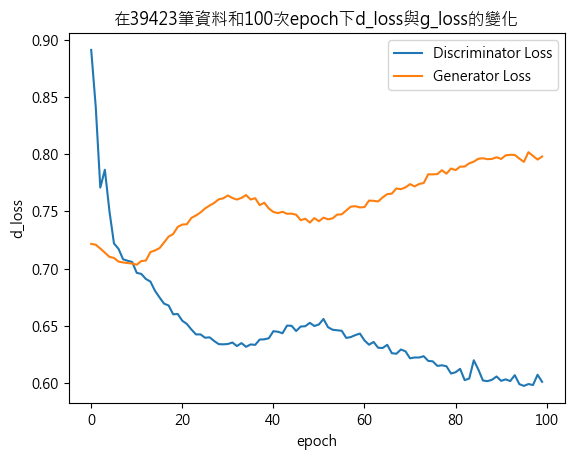

In [5]:
plt.plot(every_epoch,  every_d_loss, linestyle='-', label='Discriminator Loss')
plt.plot(every_epoch,  every_g_loss, linestyle='-', label='Generator Loss')
plt.title(f'在{data_len}筆資料和{num_epochs}次epoch下d_loss與g_loss的變化')
plt.xlabel('epoch')
plt.ylabel('d_loss')


plt.legend() 

plt.show()

利用訓練好的GAN去生成音訊特徵

In [6]:
num_samples = 10

# 創建新的MFCC數據
new_mfcc_data = []
generator.eval()  # 設置生成器為評估模式

for i in range(num_samples):
    noise = torch.randn(1, input_dim).to(device)  # 創建隨機噪聲向量
    with torch.no_grad():  # 禁用梯度計算
        generated_mfcc = generator(noise).view(1, *mfcc_shape)  # 生成數據並轉換形狀
    new_mfcc_data.append(generated_mfcc.cpu().detach().numpy())  # 將數據從GPU移到CPU，並轉換為numpy數組

new_mfcc_data = np.array(new_mfcc_data)  # 將列表轉換為numpy數組

資料做分群

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [8]:
#######################################################################
#載入mfcc為data
npy_file_list = glob(f"..\\data\\mfcc\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")

mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

all_mfcc = []
for mfcc in mfcc_list:
    all_mfcc.append(mfcc)

data = np.array(all_mfcc)
data_len = len(data)
#######################################################################

#######################################################################
#載入labelByself為labels
load_data = np.load('labelByself.npz')
labels = load_data['data']
#######################################################################



type(npy_file_list): <class 'list'>
len(npy_file_list): 39423


100%|██████████| 39423/39423 [00:06<00:00, 6214.59it/s]


type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (39423, 13, 44)


In [9]:
num_samples, mfcc_height, mfcc_width = data.shape
flat_mfcc_data = data.reshape(data.shape[0], -1) 
pca = PCA(n_components=2)
data_pca= pca.fit_transform(flat_mfcc_data)

clustering = DBSCAN(eps=3, min_samples=2).fit(data_pca)
print(clustering.labels_[:1000])


[ 0  1  2  0  1 -1  1  2  0  1  1  1  3  1  4  0  1  1  1  0  1  5  0  1
  1  6  1  1  1  1  7  2 -1  0  1  8  1  2  0  1  1  1  1  1  0  2  1  2
  1  2  1  1  1 -1  2  1  2  1  1  1  9 -1 10  1 -1  1  2  1 -1  1  1 -1
 11 12  1  1  0 13  1  1  1  2  1  2  0  1  2  1  1  1  1  1  2  1  1  1
  1  1  1  1  1  1  2  1 -1 14  1  1 15  2  1  1  0  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 16  1  1 -1  1  1 -1  1  1  1  2  1  1
  1  1  1  2  1  1  2  1  0  1  1  1  1 17  1  1  2  1  1  1  1  1 -1  1
  1  1  1  1  1 18  1  2  1  1 19  1 20  1  1  1  1  2  2  1  1  0 -1 21
 -1 -1 -1 22 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 23 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 25 -1 26 -1 -1 27
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 28 29
 -1 -1 -1 -1 -1 30 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1